# Exercise 2 - Exploring model complexity

Load again the data from the Howell study, using all rows (no selection on age).

1. Fit a linear trend to these data, comment on your findings and discuss whether the model of H vs. W could be improved using plots as basis for discussion.

In [1]:
# Loading the data
library(rethinking)
data(Howell1)
d <- Howell1

Lade nötiges Paket: rstan

Lade nötiges Paket: StanHeaders


rstan version 2.26.16 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

Lade nötiges Paket: cmdstanr

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: D:/Users/Immanuel/Documents/.cmdstan/cmdstan-2.31.0

- CmdStan version: 2.31.0

Lade nötiges Paket: parallel

rethinking (Version 2.31)


Attache Paket: 'rethinking'


Das folgende Objekt ist maskiert 'package:rstan':

    stan


Das folgende Objekt ist maskiert 'package:stats':

    rstudent




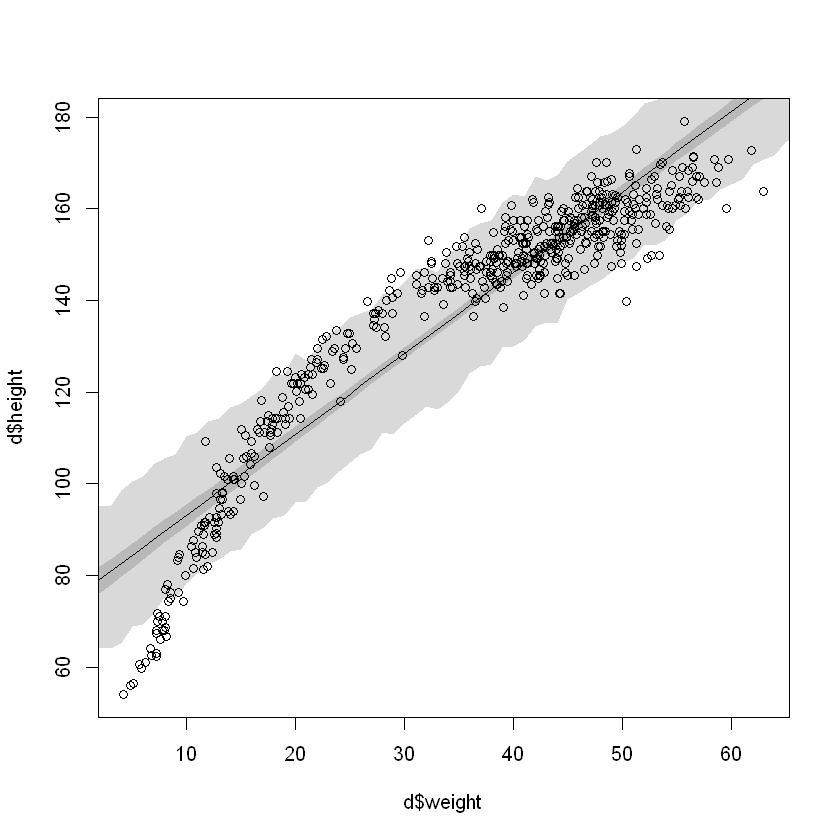

In [32]:
# Fitting a linear model to the data
model <- map(
	alist(
		height ~ dnorm(mu, sigma),
		mu <- alpha + beta * weight,
		alpha ~ dnorm(150, 30),
		beta <- dnorm(0, 10),
		sigma ~ dunif(0, 50)
	),
	data = d
)

# Extracting samples
post <- extract.samples(model)

# Defining a weight grid
weight.seq <- seq(from = 0, to = 70, by = 1)

# Calculate the expected fit and the HPDI of the fit
mu.link <- function(weight) post$alpha + post$beta * weight
mu <- sapply(weight.seq, mu.link)
mu.mean <- apply(mu, 2, mean)
mu.HPDI <- apply(mu, 2, HPDI, prob = 0.997)

# Predicting the height intervals
sim.height <- sim(model, data = list(weight = weight.seq))
height.HPDI <- apply(sim.height, 2, HPDI, 0.91)

# Plotting
plot(d$height ~ d$weight, data = d)
lines(weight.seq, mu.mean)
shade(mu.HPDI, weight.seq)
shade(height.HPDI, weight.seq)

Obviously we can use the plot to identify that the linear fit is not fitting the data particularly well. The linear fit overestimates and underestimates the data while claiming a high precision. Thus the model is not accurate. I would recommend using a logarithmic, square-root or polynomial fit of 3rd degree.

2. Use different models of your choosing and using map, investigate on whether you can identify one model that fits the data better than in (1). Use the range of diagnosis tools (plots, vcov, precis/summary) as a basis for discussion.

Lets use a logarithmic model.

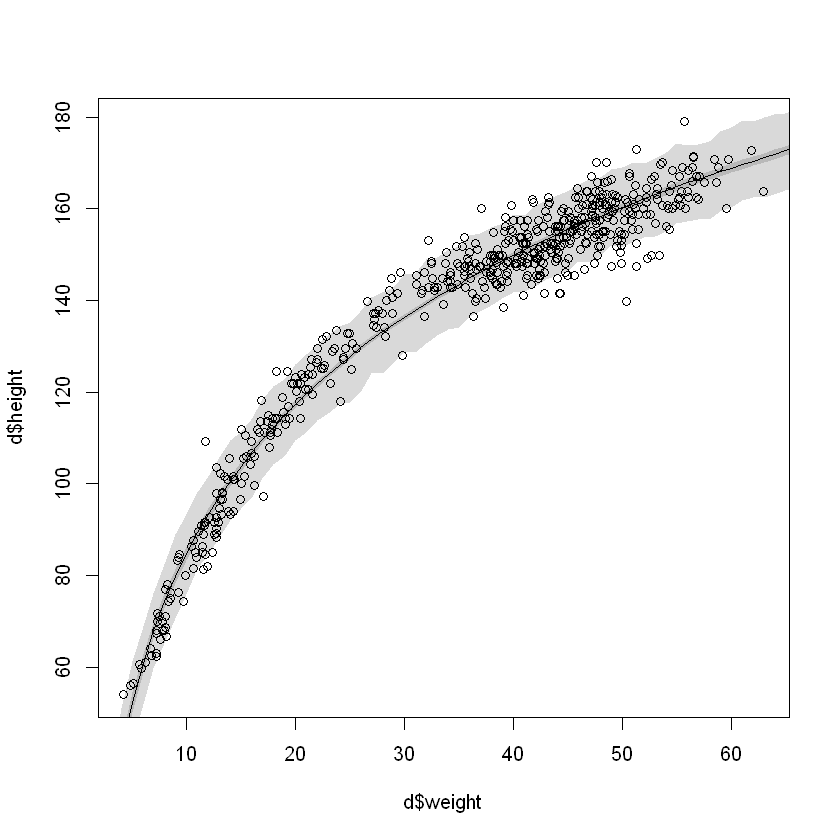

In [33]:
# Fitting a logarithmic model to the data
model <- map(
	alist(
		height ~ dnorm(mu, sigma),
		mu <- alpha + beta * log(weight),
		alpha ~ dnorm(150, 30),
		beta <- dnorm(0, 10),
		sigma ~ dunif(0, 50)
	),
	data = d
)

# Extracting samples
post <- extract.samples(model)

# Defining a weight grid
weight.seq <- seq(from = 0, to = 70, by = 1)

# Calculate the expected fit and the HPDI of the fit
mu.link <- function(weight) post$alpha + post$beta * log(weight)
mu <- sapply(weight.seq, mu.link)
mu.mean <- apply(mu, 2, mean)
mu.HPDI <- apply(mu, 2, HPDI, prob = 0.997)

# Predicting the height intervals
sim.height <- sim(model, data = list(weight = weight.seq))
height.HPDI <- apply(sim.height, 2, HPDI, 0.91)

# Plotting
plot(d$height ~ d$weight, data = d)
lines(weight.seq, mu.mean)
shade(mu.HPDI, weight.seq)
shade(height.HPDI, weight.seq)

As such the logarithmic fit is better than the linear fit as we can see in the plot. We also have further tools to find the better model, such as the covariance matrix below.

,alpha,beta,sigma
alpha,1.779,-0.503,0.005
beta,-0.503,0.146,-0.002
sigma,0.005,-0.002,0.024


Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"


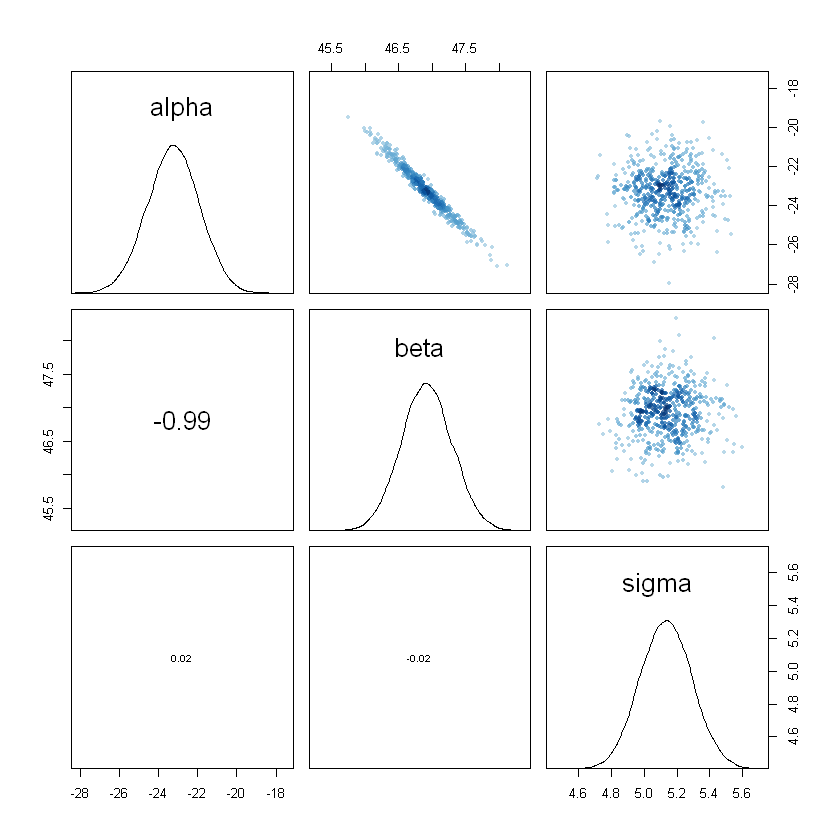

In [35]:
round(vcov(model), 3)
pairs(model)

There is obviously a dependency between the offset and the parameter of the logarithm.